# Comparison of trajectories for different regularization terms

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt



# Juptyer magic: For export. Makes the plots size right for the screen
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Data preparation

Data point of X: [0.08267714 0.27641062] 
Data type X: float64

Data point of y: 1 
Data type y: float64


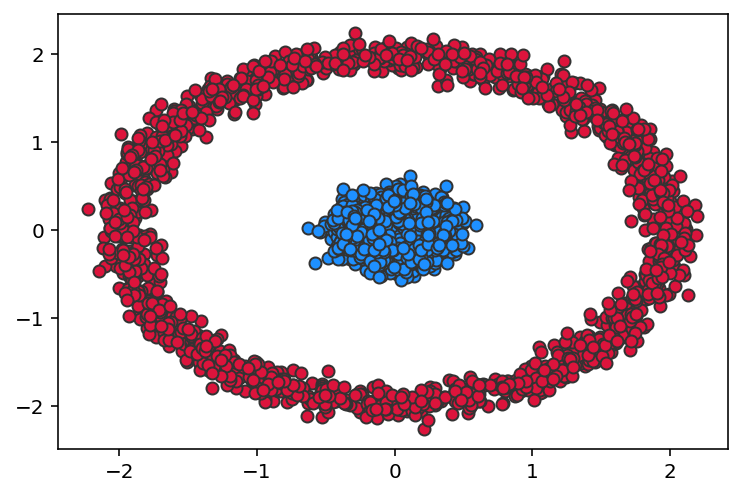

In [2]:
#We load a typical toy dataset that requires a nonlinear classification model to achieve high accuracy
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#the noise describes how large the standard deviation of the data distribution is
noise = 0.05

#Load 3000 instances of data points

# X, y = make_moons(n_samples = 3000, noise = noise)

#alternative toy data set
X, y = make_circles(3000, noise=noise, factor=0.15)
X = StandardScaler().fit_transform(X)


print('Data point of X:', X[0], '\nData type X:', X.dtype)
print('\nData point of y:', y[0], '\nData type y:', X.dtype)

#Visualizing the data
data_0 = X[y == 0]
data_1 = X[y == 1]
fig = plt.figure()
plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", color = 'crimson')
plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", color = 'dodgerblue')
plt.show()

As typical for machine learning algorithms, we split the data into a training set and test set.  
To use the pytorch frameset, we recast the data as tensors and create Dataloaders used to conveniently load the training and test data during training and validation.

In [3]:
from torch.utils.data import DataLoader,TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2 )

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)

dataloader = DataLoader(data_line, batch_size=64)
dataloader_viz = DataLoader(test, batch_size=128)

In [4]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], '\n', y_test[:10])
    break
    

tensor([[-1.9394, -0.6783],
        [ 1.7436,  0.9888],
        [ 0.2398,  0.1065],
        [-1.9393, -0.6645],
        [ 0.1221,  0.2584],
        [ 0.2217,  0.0331],
        [ 0.2676, -1.9618],
        [ 0.1406,  0.2934],
        [-0.1850, -0.1139],
        [-1.8248,  0.3410]]) 
 tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0])


### Model dynamics without regularization

In [5]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5.0, 6  
dt = T/num_steps
bound = 0.
fp = False
cross_entropy = True


# non_linearity = 'relu'
non_linearity = 'tanh' 
# architecture = 'bottleneck' 
architecture = 'inside'

v_steps = 5
training = True #train new network or load saved one

anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 
print(anode)


from models.training import Trainer

trainer_anode = Trainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, 
                         bound=bound, fixed_projector=fp, verbose = True) 

print("Model's state_dict:")
for param_tensor in anode.state_dict():
    print(param_tensor, "\t", anode.state_dict()[param_tensor].size())

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)
Model's state_dict:
flow.dynamics.fc2_time.0.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.0.bias 	 torch.Size([2])
flow.dynamics.fc2_time.1.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.1.bias 	 torch.Size([2])
flow.dynamics.fc2_time.2.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.2.bias 	 torch.Size([2])
flow.dynamics.fc2_time.3.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time

### Model dynamics and training for doublebackpropagation training

In [6]:
from models.training import doublebackTrainer

eps = 0.3


node = NeuralODE(device, data_dim, hidden_dim, adjoint=False, augment_dim=0, non_linearity=non_linearity,
                            architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
        # if pretrained:
        #     node.load_state_dict(torch.load('rob_node.pth'))


optimizer_node = torch.optim.Adam(node.parameters(), lr=1e-3)  # weight decay parameter modifies norm
       
          
trainer_eps_node = doublebackTrainer(node, optimizer_node, device, cross_entropy=cross_entropy,
                                        bound=bound, fixed_projector=fp, verbose=True, eps=eps, l2_factor = 0)


In [7]:
num_epochs = 150 #number of optimization runs in which the dataset is used for gradient decent

trainer_anode.train(dataloader, num_epochs)


Epoch 0/38
Loss: 0.704
Accuracy: 0.688


/home/np1/staff/woehrer/FAUbox/Python/borjan dynamical.systems/models/training.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)



Epoch 10/38
Loss: 0.702
Accuracy: 0.562

Epoch 20/38
Loss: 0.700
Accuracy: 0.625

Epoch 30/38
Loss: 0.612
Accuracy: 0.688
Epoch 1: 0.680

Epoch 0/38
Loss: 0.670
Accuracy: 0.734

Epoch 10/38
Loss: 0.667
Accuracy: 0.703

Epoch 20/38
Loss: 0.667
Accuracy: 0.750

Epoch 30/38
Loss: 0.588
Accuracy: 0.828
Epoch 2: 0.650

Epoch 0/38
Loss: 0.648
Accuracy: 0.781

Epoch 10/38
Loss: 0.642
Accuracy: 0.734

Epoch 20/38
Loss: 0.643
Accuracy: 0.781

Epoch 30/38
Loss: 0.571
Accuracy: 0.859
Epoch 3: 0.630

Epoch 0/38
Loss: 0.632
Accuracy: 0.812

Epoch 10/38
Loss: 0.624
Accuracy: 0.766

Epoch 20/38
Loss: 0.624
Accuracy: 0.781

Epoch 30/38
Loss: 0.557
Accuracy: 0.859
Epoch 4: 0.614

Epoch 0/38
Loss: 0.620
Accuracy: 0.812

Epoch 10/38
Loss: 0.608
Accuracy: 0.781

Epoch 20/38
Loss: 0.608
Accuracy: 0.766

Epoch 30/38
Loss: 0.544
Accuracy: 0.844
Epoch 5: 0.601

Epoch 0/38
Loss: 0.609
Accuracy: 0.797

Epoch 10/38
Loss: 0.595
Accuracy: 0.781

Epoch 20/38
Loss: 0.594
Accuracy: 0.781

Epoch 30/38
Loss: 0.532
Acc

In [8]:
trainer_eps_node.train(dataloader, num_epochs)



Epoch 0/38
Loss: 0.716
Accuracy: 0.578

Epoch 10/38
Loss: 0.640
Accuracy: 0.734

Epoch 20/38
Loss: 0.585
Accuracy: 0.750

Epoch 30/38
Loss: 0.575
Accuracy: 0.797
Epoch 1: 0.649

Epoch 0/38
Loss: 0.678
Accuracy: 0.688

Epoch 10/38
Loss: 0.621
Accuracy: 0.781

Epoch 20/38
Loss: 0.582
Accuracy: 0.719

Epoch 30/38
Loss: 0.570
Accuracy: 0.812
Epoch 2: 0.632

Epoch 0/38
Loss: 0.660
Accuracy: 0.672

Epoch 10/38
Loss: 0.612
Accuracy: 0.766

Epoch 20/38
Loss: 0.580
Accuracy: 0.719

Epoch 30/38
Loss: 0.567
Accuracy: 0.766
Epoch 3: 0.622

Epoch 0/38
Loss: 0.647
Accuracy: 0.688

Epoch 10/38
Loss: 0.603
Accuracy: 0.734

Epoch 20/38
Loss: 0.576
Accuracy: 0.766

Epoch 30/38
Loss: 0.563
Accuracy: 0.750
Epoch 4: 0.613

Epoch 0/38
Loss: 0.635
Accuracy: 0.688

Epoch 10/38
Loss: 0.594
Accuracy: 0.750

Epoch 20/38
Loss: 0.570
Accuracy: 0.781

Epoch 30/38
Loss: 0.557
Accuracy: 0.750
Epoch 5: 0.604

Epoch 0/38
Loss: 0.624
Accuracy: 0.672

Epoch 10/38
Loss: 0.584
Accuracy: 0.750

Epoch 20/38
Loss: 0.561
Accu

## Generate a gif of the evolution of the input points through the neural network

In [9]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif')
    trajectory_gif(node, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory_db.gif')
    
    break

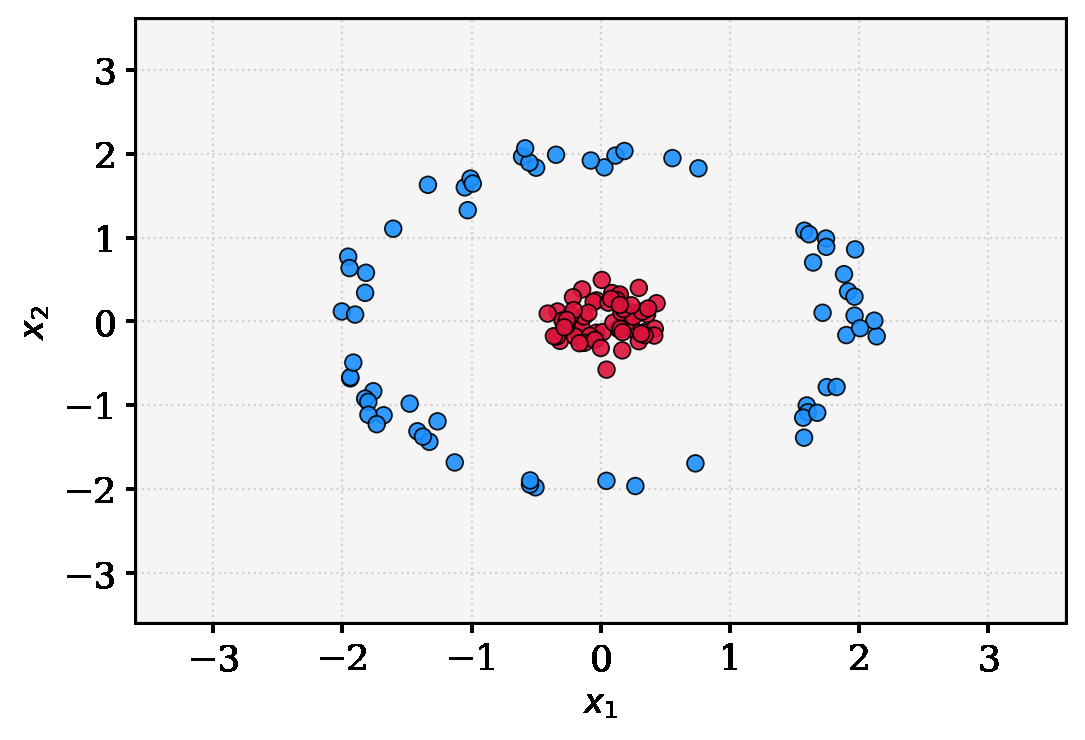

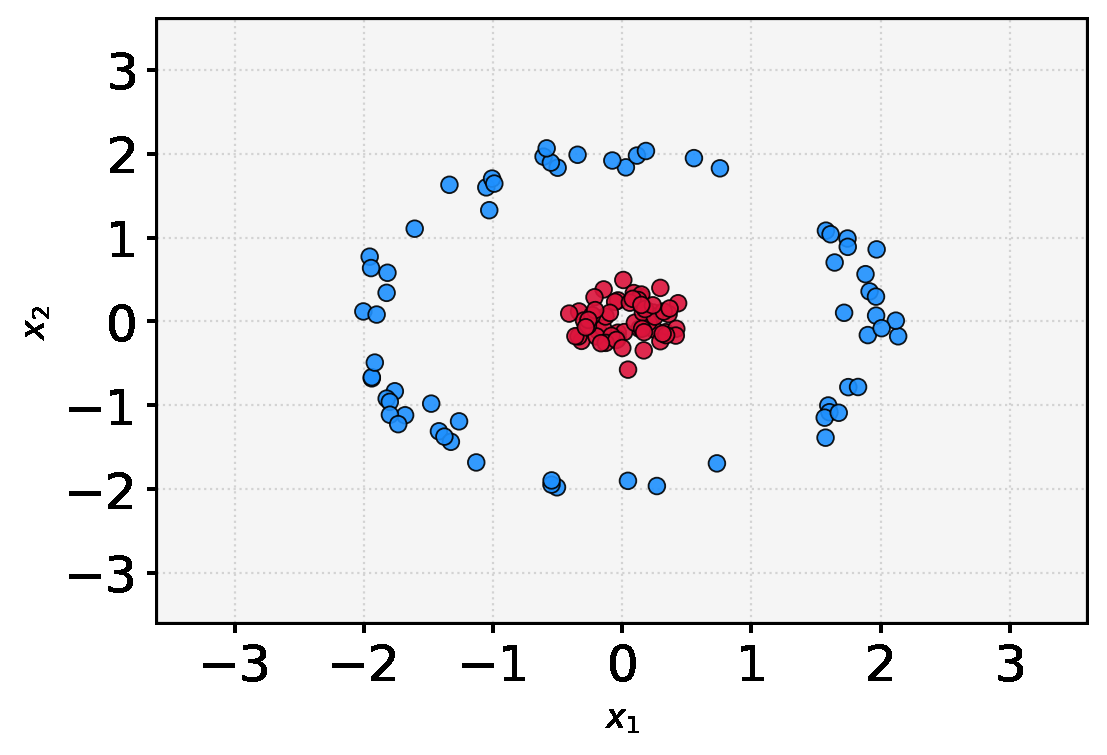

In [10]:
#Display of the generated gif

from IPython.display import Image, display
# Image(filename="trajectory.gif", retina = True)
img1 = Image(filename="trajectory_db.gif", retina = True)
img2 = Image(filename="trajectory.gif", retina = True)

display(img1, img2)